# Preface
Maintenance of equipment is a critical activity for any business involving machines. Predictive maintenance is the method of scheduling maintenance based on the prediction about the failure time of any equipment. The machine learning models is constructed based on the datasets from turbo fan engine data from the Prognostics Data Repository of NASA. Using a training set, a model was constructed and was verified with a test data set. The results obtained were compared with the actual results to calculate the accuracy and the algorithm that results in maximum accuracy is identified. We have selected two machine learning algorithms for comparing the prediction accuracy.


In [1]:
import math
import collections
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler

# Visualization Libraries
import seaborn as sns
import matplotlib.pyplot as plt

# Tuning & Splitting Libraries
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# Loading Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Model Evaluation Liabraries
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, accuracy_score, r2_score, roc_auc_score, precision_score, recall_score, f1_score

sns.set_style('darkgrid')

# Data
Our data includes data of 100 engines, each doing their respective number of cycles as per their functional lifecycle. During each cycle the sensors installed collects the data in each respective cycle. Based on this collected data we need to build a model which would predict the remaining useful life(RUL, time before which engine goes for maintenance to avoid unexpected breakdown) of a already/newly installed engine based on its current cycle data

In [6]:
# Reading the data

# jet_data = pd.read_csv('C:/Users/prathish/Downloads/CMaps/train_FD001.txt', sep=" ", header=None)

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='lrvvakIwcyLQUVQ12x2Wy08HkFK1Futc6qrOFHu6I2lA',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'custommodeldeployment-donotdelete-pr-hcfp3onrensimw'
object_key = 'dataset.xlsx'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']

jet_data = pd.read_excel(body.read())
jet_data.head()

# jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
#                     ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
#                     ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
#                     ,"sensor20","sensor21","sensor22","sensor23"]

# jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

# jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
# jet_id_and_rul.set_index('id', inplace=True)

,Unnamed: 0,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,...,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,sensor22,sensor23
0,0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,...,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,NaN,NaN
1,1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,...,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,NaN,NaN
2,2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,...,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,NaN,NaN
3,3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,...,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,NaN,NaN
4,4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,...,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,NaN,NaN


In [7]:
jet_data = jet_data.iloc[: , 1:]

In [9]:
jet_data.columns = ["id","cycle","op1","op2","op3","sensor1","sensor2","sensor3","sensor4","sensor5"
                    ,"sensor6","sensor7","sensor8","sensor9","sensor10","sensor11","sensor12","sensor13"
                    ,"sensor14","sensor15","sensor16","sensor17","sensor18","sensor19"
                    ,"sensor20","sensor21","sensor22","sensor23"]

jet_data.drop(['sensor22', 'sensor23'], axis=1, inplace=True)

jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()
jet_id_and_rul.set_index('id', inplace=True)

In [10]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044


# Data Manipulation
The test data does not have RUL column so for model validation purposes we will add the column externally in the dataframe

In [11]:
def RUL_calculator(df, df_max_cycles):
    max_cycle = df_max_cycles["cycle"]
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    result_frame["RUL"] = result_frame["max_cycle"] - result_frame["cycle"] 
    result_frame.drop(['max_cycle'], axis=1, inplace=True)
    return result_frame

jet_data = RUL_calculator(jet_data, jet_id_and_rul)

In [12]:
jet_data.describe()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705,107.807862
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251,68.880990
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200,0.000000
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800,51.000000
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900,103.000000
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800,155.000000
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400,361.000000


In [13]:
jet_data.head()

,id,cycle,op1,op2,op3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21,RUL
0,1,1,-0.0007,-0.0004,100,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100,38.95,23.3442,189
3,1,4,0.0007,0.0000,100,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100,38.90,23.4044,187


# Visualizing Data
We will visualize the data to determine the relevance of data and figure out the model determining attributes

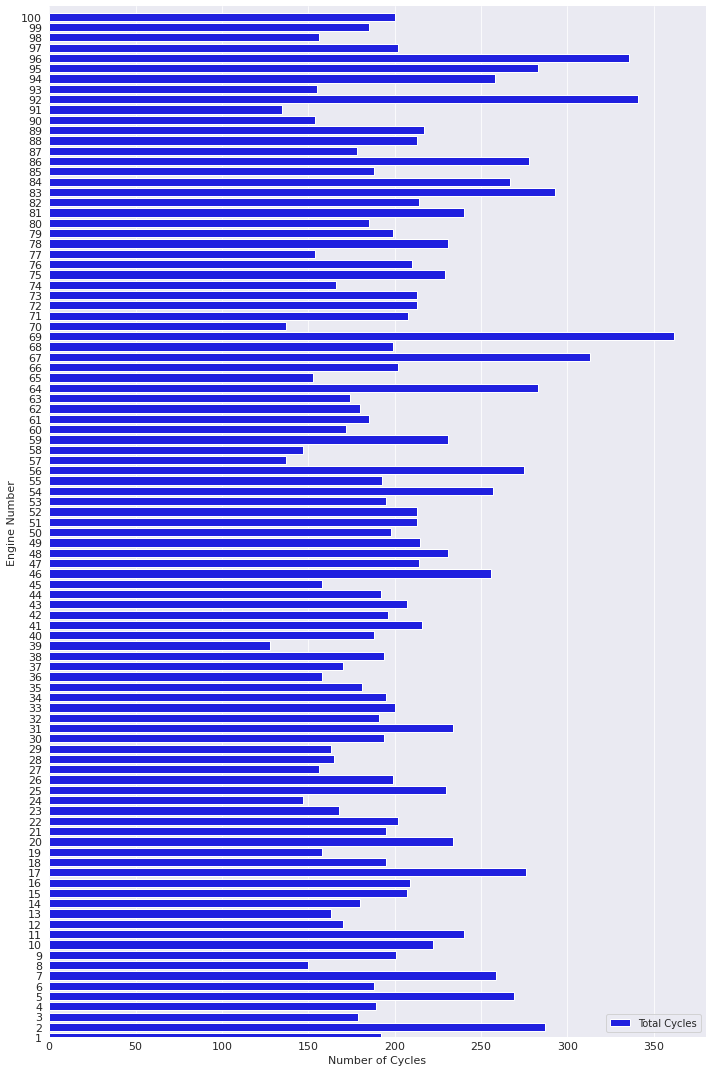

In [14]:
jet_id_and_rul = jet_data.groupby(['id'])[["id" ,"cycle"]].max()

f, ax = plt.subplots(figsize=(10, 15))
sns.set_color_codes("pastel")
sns.barplot(x="cycle", y="id", data=jet_id_and_rul, label="Total Cycles", color="blue", orient = 'h', dodge=False)
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(ylim=(0, 100), ylabel="",xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
ax.tick_params(labelsize=11)
ax.tick_params(length=0, axis='x')
ax.set_ylabel("Engine Number", fontsize=11)
ax.set_xlabel("Number of Cycles", fontsize=11)
plt.tight_layout()
plt.show()

Mean number of cycles after which jet engine fails is 206


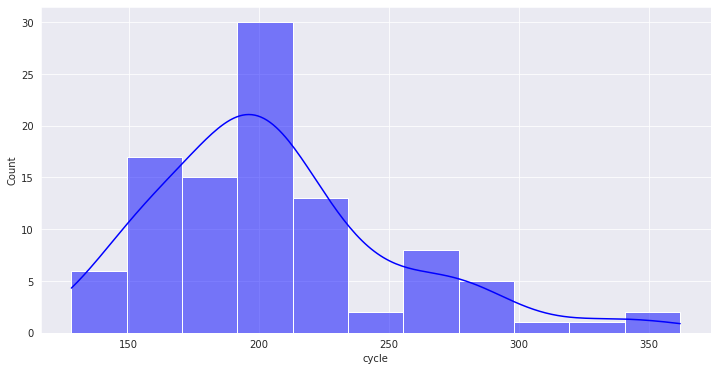

In [15]:
plt.subplots(figsize=(12, 6))
sns.histplot(jet_id_and_rul["cycle"], kde = True, color='blue');
print("Mean number of cycles after which jet engine fails is "+ str(math.floor(jet_id_and_rul["cycle"].mean())))

As we could see there are many sensor data which aren't following the normal distribution, we will tend to ignore those sensors for our model training. We would try to reduce the curse of dimensionality by doing so.

# Correlation Matrix
To see wheather the selected attributes are not related to each other. This way we will be able to reduce some more attributes, making our model free from overfitting.

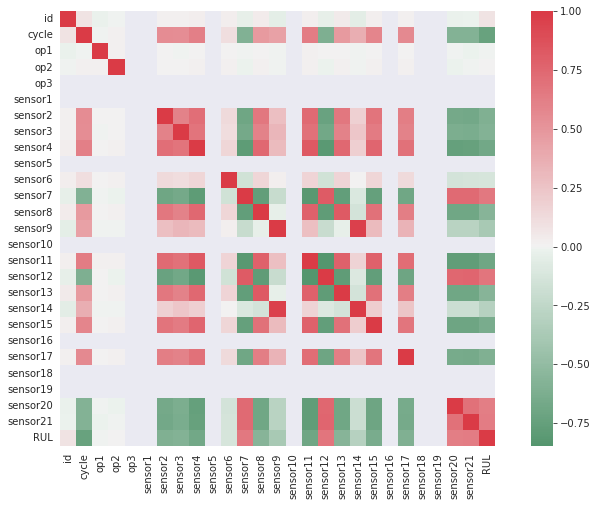

In [16]:
plt.figure(figsize=(13,8))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_data.corr(), cmap =cmap, center=0, annot=False, square=True);

# Deletion of non contributing parameters into the analysis
Using the above correlation heatmap, We can safely ignore the parameters with lesser correlation with RUL. we can infer that the following parameters are not related to the RUL.

id, op1, op2, op3
sensor1, sensor5, sensor6, sensor10
sensor16, sensor18, sensor19

In [17]:
jet_relevant_data = jet_data.drop(["cycle", "op1", "op2", "op3", "sensor1", "sensor5", "sensor6", "sensor10", "sensor16", 
                                  "sensor18", "sensor19", "sensor14", "sensor13", "sensor12", "sensor11"], axis=1)

In [137]:
jet_relevant_data

,id,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor15,sensor17,sensor20,sensor21,RUL
0,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,8.4195,392,39.06,23.4190,191
1,1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,8.4318,392,39.00,23.4236,190
2,1,642.35,1587.99,1404.20,554.26,2388.08,9052.94,8.4178,390,38.95,23.3442,189
3,1,642.35,1582.79,1401.87,554.45,2388.11,9049.48,8.3682,392,38.88,23.3739,188
4,1,642.37,1582.85,1406.22,554.00,2388.06,9055.15,8.4294,393,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,643.49,1597.98,1428.63,551.43,2388.19,9065.52,8.4956,397,38.49,22.9735,4
20627,100,643.54,1604.50,1433.58,550.86,2388.23,9065.11,8.5139,395,38.30,23.1594,3
20628,100,643.42,1602.46,1428.18,550.94,2388.24,9065.90,8.5646,398,38.44,22.9333,2
20629,100,643.23,1605.26,1426.53,550.68,2388.25,9073.72,8.5389,395,38.29,23.0640,1


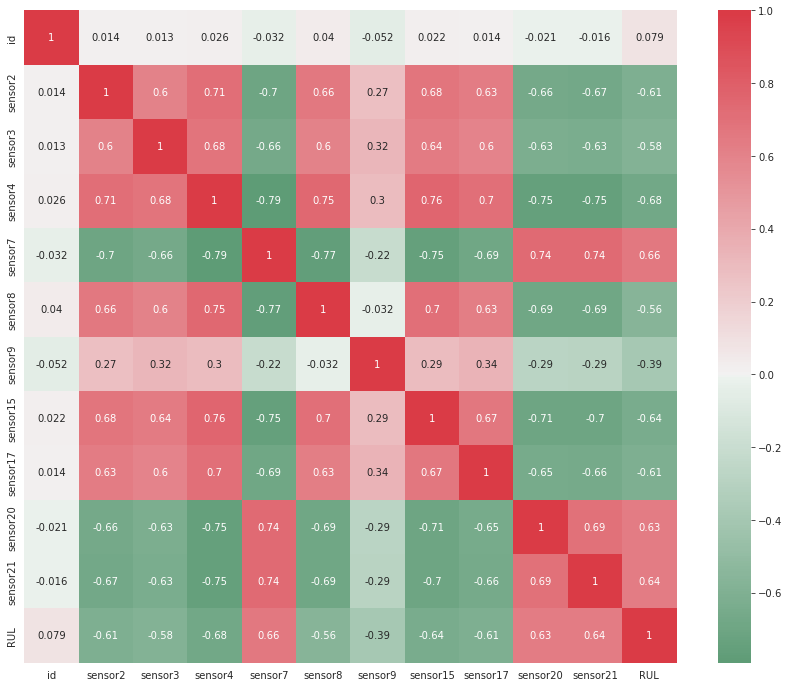

In [18]:
plt.figure(figsize=(15, 12))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(jet_relevant_data.corr(), cmap =cmap, center=0, annot=True, square=True);

In [19]:
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(jet_relevant_data.drop(['id', 'RUL'], axis=1))
scaled_features = pd.DataFrame(scaled_features, columns=jet_relevant_data.drop(['id', 'RUL'], axis=1).columns)

In [20]:
scaled_features['id'] = jet_relevant_data['id']
scaled_features['RUL'] = jet_relevant_data['RUL']

In [21]:
scaled_features.head()

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor15,sensor17,sensor20,sensor21,id,RUL
0,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.363986,0.333333,0.713178,0.724662,1,191
1,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.411312,0.333333,0.666667,0.731014,1,190
2,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.357445,0.166667,0.627907,0.621375,1,189
3,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166603,0.333333,0.573643,0.662386,1,188
4,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.402078,0.416667,0.589147,0.704502,1,187


In [22]:
data = scaled_features.copy()

In [23]:
cycle=30
data['label'] = data['RUL'].apply(lambda x: 1 if x <= cycle else 0)

In [24]:
y = data['label']
X = data.drop(['RUL', 'id', 'label'], axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=3)

print('X_train shape : ',X_train.shape)
print('X_test shape : ',X_test.shape)
print('y_train shape : ',y_train.shape)
print('y_test shape : ',y_test.shape)

X_train shape :  (16504, 10)
X_test shape :  (4127, 10)
y_train shape :  (16504,)
y_test shape :  (4127,)


# Model Building

After the extensive EDA, we have some idea about the data. The data seems linearly separable 

In [26]:
from sklearn.metrics import accuracy_score
model1 = LogisticRegression()
model1.fit(X_train, y_train)
model1_pred=model1.predict(X_test)
acc1=accuracy_score(y_test, model1_pred)
print("Accuracy for Logistic Regressipn:",acc1)

Accuracy for Logistic Regressipn: 0.9563847831354495


In [136]:
X_test

,sensor2,sensor3,sensor4,sensor7,sensor8,sensor9,sensor15,sensor17,sensor20,sensor21
9775,0.310241,0.304556,0.386226,0.618357,0.257576,0.208068,0.495575,0.416667,0.651163,0.442833
17585,0.653614,0.496621,0.726536,0.342995,0.545455,0.235978,0.645633,0.666667,0.449612,0.295360
16843,0.599398,0.651188,0.424544,0.470209,0.454545,0.136947,0.515583,0.583333,0.503876,0.458023
12869,0.463855,0.374319,0.506415,0.608696,0.287879,0.191196,0.317815,0.416667,0.674419,0.339409
11388,0.734940,0.565947,0.730756,0.293076,0.621212,0.073768,0.745671,0.666667,0.131783,0.203259
...,...,...,...,...,...,...,...,...,...,...
10389,0.439759,0.459342,0.415598,0.690821,0.272727,0.180517,0.310889,0.333333,0.689922,0.629108
14501,0.683735,0.438849,0.531904,0.381643,0.318182,0.097236,0.447480,0.583333,0.465116,0.553576
12179,0.439759,0.457598,0.307225,0.608696,0.318182,0.133357,0.512890,0.500000,0.534884,0.429163
6653,0.108434,0.362546,0.419818,0.640902,0.257576,0.176972,0.453251,0.416667,0.612403,0.522370


In [27]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)
model2_pred=model2.predict(X_test)
acc2=accuracy_score(y_test, model2_pred)
print("Accuracy for KNN:",acc2)

Accuracy for KNN: 0.9549309425732978


In [28]:
model3 = DecisionTreeClassifier()
model3.fit(X_train, y_train)
model3_pred=model3.predict(X_test)
acc3=accuracy_score(y_test, model3_pred)
print("Accuracy for Decision Tree Classifier:",acc3)

Accuracy for Decision Tree Classifier: 0.9433002180760843


In [29]:
model4 = SVC(kernel='linear')
model4.fit(X_train, y_train)
model4_pred=model4.predict(X_test)
acc4=accuracy_score(y_test, model4_pred)
print("Accuracy for Support Vector Machine:",acc4)

Accuracy for Support Vector Machine: 0.9566270898958081


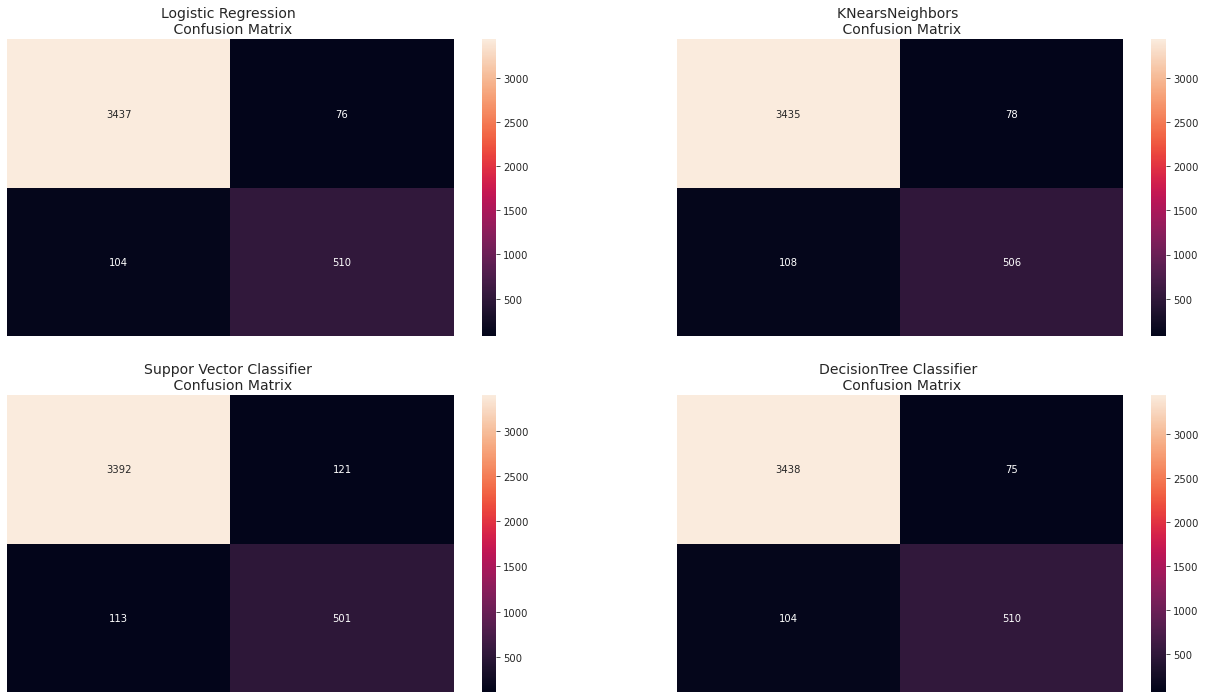

In [30]:
log_reg_cf = confusion_matrix(y_test, model1_pred)
kneighbors_cf = confusion_matrix(y_test, model2_pred)
svc_cf = confusion_matrix(y_test, model3_pred)
tree_cf = confusion_matrix(y_test, model4_pred)

fig, ax = plt.subplots(2, 2,figsize=(22,12))

sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap='rocket', fmt='g')
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap='rocket', fmt='g')
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap='rocket', fmt='g')
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap='rocket', fmt='g')
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

plt.show()

In [94]:
!pip install ibm_watson_machine_learning

In [124]:
from ibm_watson_machine_learning import APIClient

wml_credentials = {
    "url": "https://us-south.ml.cloud.ibm.com",
    "apikey": "xU7wUCiLdUHS2Y9iDdLma2qNSXQyWBzohz-ZlQCOB1Ss",
    "version": "4.0.4"
}

client = APIClient(wml_credentials)

In [126]:
client

In [127]:
def guid_from_space_name(client, space_name):
    space = client.spaces.get_details()
    return(next(item for item in space['resources'] if item['entity']['name'] == space_name)['metadata']['id'])

In [128]:
space_uid = guid_from_space_name(client, 'IBMModelDeploymentSpace')
print("Space UID :", space_uid)

Space UID : 54ed525f-fa1f-48dc-8e3f-96a5581bef17


In [129]:
client.set.default_space(space_uid)

'SUCCESS'

In [130]:
client.software_specifications.list()

-----------------------------  ------------------------------------  ----
NAME                           ASSET_ID                              TYPE
default_py3.6                  0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12      020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt     069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6        09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12     09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9      0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6          0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                     0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod   1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6              10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl      111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt22.2-py3.10        125b6d9

In [132]:
software_spec_uid = client.software_specifications.get_uid_by_name("runtime-22.1-py3.9")
print(software_spec_uid)

12b83a17-24d8-5082-900f-0ab31fbfd3cb


In [111]:
metadata = {
            client.repository.ModelMetaNames.NAME: 'Logistic Regression Engine Model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

published_model = client.repository.store_model(model=model1, meta_props=metadata)

In [133]:
metadata2 = {
            client.repository.ModelMetaNames.NAME: 'K-Nearest Neighbours Engine Model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

published_model2 = client.repository.store_model(model=model2, meta_props=metadata2)

In [134]:
metadata3 = {
            client.repository.ModelMetaNames.NAME: 'Decision Tree Classifier Engine Model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

published_model3 = client.repository.store_model(model=model3, meta_props=metadata3)

In [135]:
metadata4 = {
            client.repository.ModelMetaNames.NAME: 'Support Vector Machine Engine Model',
            client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0',
            client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid
}

published_model4 = client.repository.store_model(model=model4, meta_props=metadata4)